In [1]:
import stistools
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, ZScaleInterval
import numpy as np
import os

/home/serat/miniconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/serat/miniconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


In [2]:
def plot_image(file, extension=1, title=""):
    with fits.open(file) as hdu:
        data = hdu[extension].data
    norm = ImageNormalize(data, interval=ZScaleInterval())
    plt.figure(figsize=(10, 10))
    plt.imshow(data, origin='lower', norm=norm, cmap='gray')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [3]:
%env lref /home/serat/Downloads/AGN/data/raw/
%env oref /home/serat/Downloads/AGN/data/raw/

env: lref=/home/serat/Downloads/AGN/data/raw/
env: oref=/home/serat/Downloads/AGN/data/raw/


In [4]:
stistools.x1d.x1d('/home/serat/Downloads/AGN/data/reduced/of0a02030_lacos_new.fits', output='/home/serat/Downloads/AGN/data/of0a02030_1D.fits', 
                      backcorr='perform', 
                      ctecorr='perform', 
                      dispcorr='perform', 
                      helcorr='perform', 
                      fluxcorr='perform', 
                      sporder=None, 
                      a2center=None, 
                      maxsrch=None, 
                      globalx=False, 
                      extrsize=None, 
                      bk1size=None, 
                      bk2size=None, 
                      bk1offst=None, 
                      bk2offst=None, 
                      bktilt=None, 
                      backord=None, bksmode='median', bksorder=3, 
                      blazeshift=None, 
                      algorithm='unweighted', 
                      xoffset=None, 
                      verbose=True,
                      timestamps=False, 
                      trailer='/home/serat/Downloads/AGN/data/reduced/sample_new_trl_new.log')
print('Done.')

Appending to trailer file /home/serat/Downloads/AGN/data/reduced/sample_new_trl_new.log
Running x1d on /home/serat/Downloads/AGN/data/reduced/of0a02030_lacos_new.fits
  ['cs6.e', '/home/serat/Downloads/AGN/data/reduced/of0a02030_lacos_new.fits', '/home/serat/Downloads/AGN/data/of0a02030_1D.fits', '-v', '-back', '-cte', '-disp', '-hel', '-flux', '-bm', '-bo', '3', '-a', 'unweighted']
Done.


# Hbeta

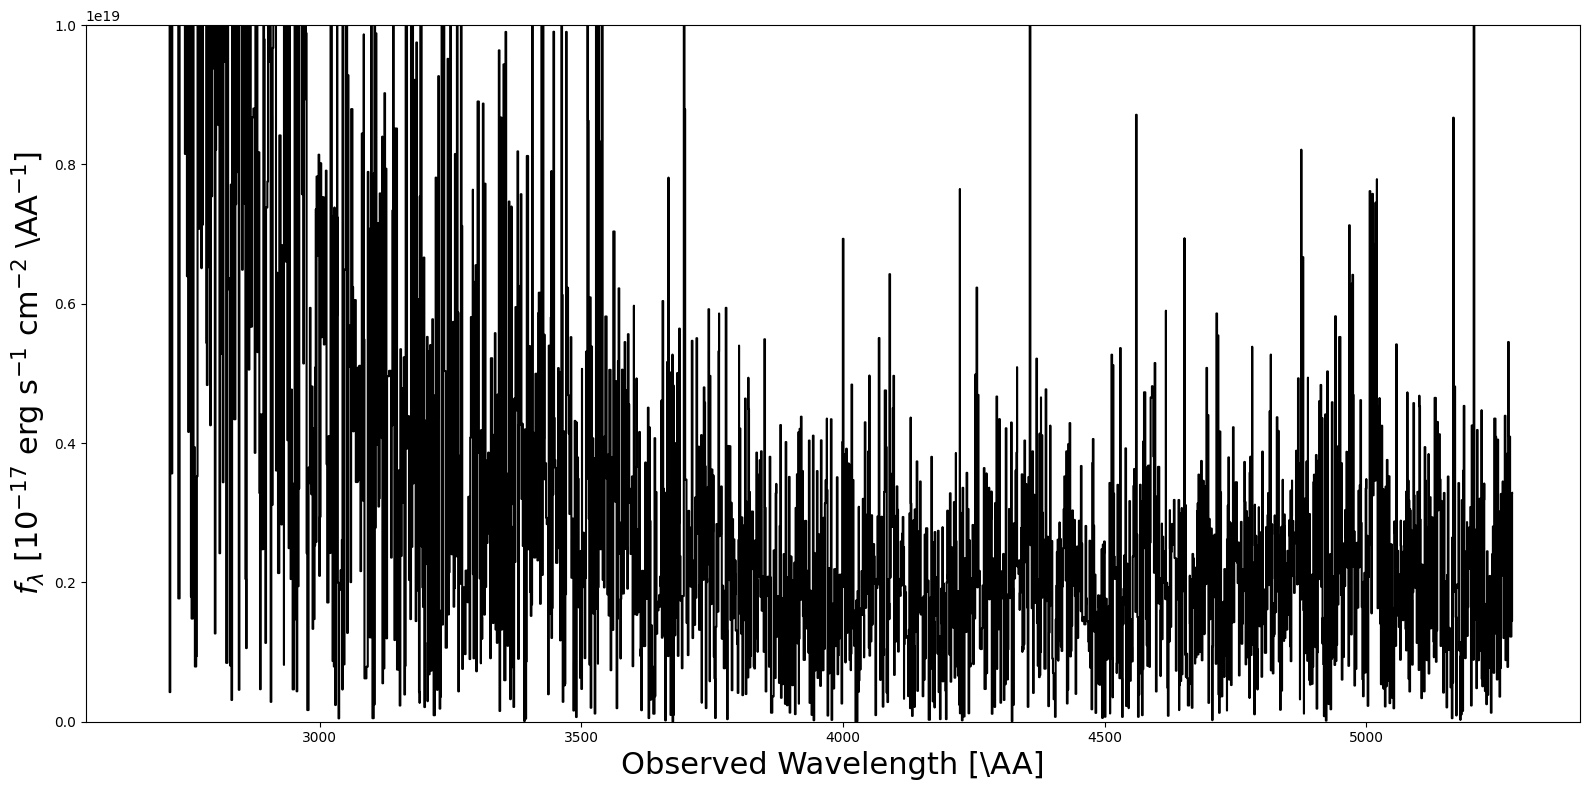

In [5]:
sx1_file='/home/serat/Downloads/AGN/data/region1.fits'
with fits.open(sx1_file) as new_hdu:
    new_dat = new_hdu[1].data
    wave_new = new_dat['wavelength']
    flux_new = (1e17) * new_dat['flux']
    err_new = (1e17) * new_dat['error']
   
   # Create a mask for positive flux values
mask = flux_new > 0
   # Apply the mask
wave_new = wave_new[mask]
flux_new = flux_new[mask]
err_new = err_new[mask]

ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
xtit = 'Observed Wavelength [\AA]'

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
ax1.plot(wave_new / (1 + 0.081), flux_new, drawstyle='steps-mid', color='k')
ax1.set_ylim([0, 1e19])
# ax1.set_xlim([2800, 5800])
ax1.set_ylabel(ytit, size=22)
ax1.set_xlabel(xtit, size=22)
plt.tight_layout()
plt.show()

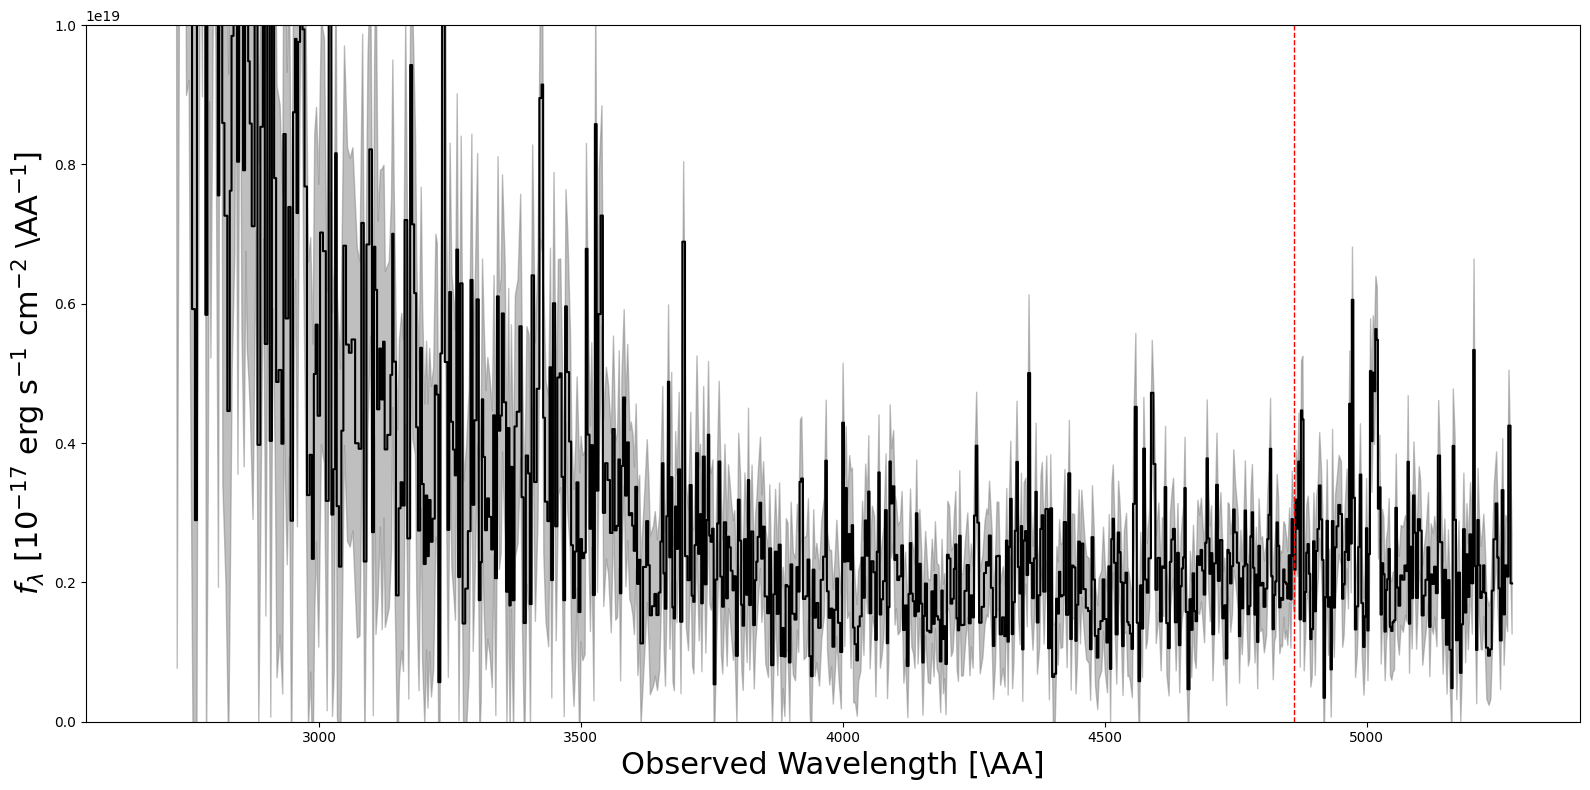

In [6]:
def bin_data(wave, flux, err, bin_size):
    # Determine the number of bins
    num_bins = len(wave) // bin_size
    binned_wave = np.zeros(num_bins)
    binned_flux = np.zeros(num_bins)
    binned_err = np.zeros(num_bins)
    
    for i in range(num_bins):
        start = i * bin_size
        end = start + bin_size
        binned_wave[i] = np.mean(wave[start:end])
        binned_flux[i] = np.mean(flux[start:end])
        binned_err[i] = np.sqrt(np.sum(err[start:end]**2)) / bin_size  # Assuming errors add in quadrature
    
    return binned_wave, binned_flux, binned_err


bin_size = 3

new_hdu = fits.open(sx1_file)
new_dat = new_hdu[1].data
wave_new = new_dat['wavelength']
flux_new = (1e17) * new_dat['flux']
err_new = (1e17) * new_dat['error']

# Bin the data
binned_wave, binned_flux, binned_err = bin_data(wave_new, flux_new, err_new, bin_size)

# Plot the binned data
ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
xtit = 'Observed Wavelength [\AA]'
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
ax1.plot(binned_wave / (1 + 0.081), binned_flux, drawstyle='steps-mid', color='k')
ax1.fill_between(binned_wave / (1 + 0.081), binned_flux - binned_err, binned_flux + binned_err, color='gray', alpha=0.5)
ax1.axvline(x=4861, color='r', linestyle='--', linewidth=1, label='H-beta (4861 \AA)')
ax1.set_ylim([0, 1e19])
# ax1.set_xlim([2800, 5800])
ax1.set_ylabel(ytit, size=22)
ax1.set_xlabel(xtit, size=22)
plt.tight_layout()
plt.show()

# Mid-region

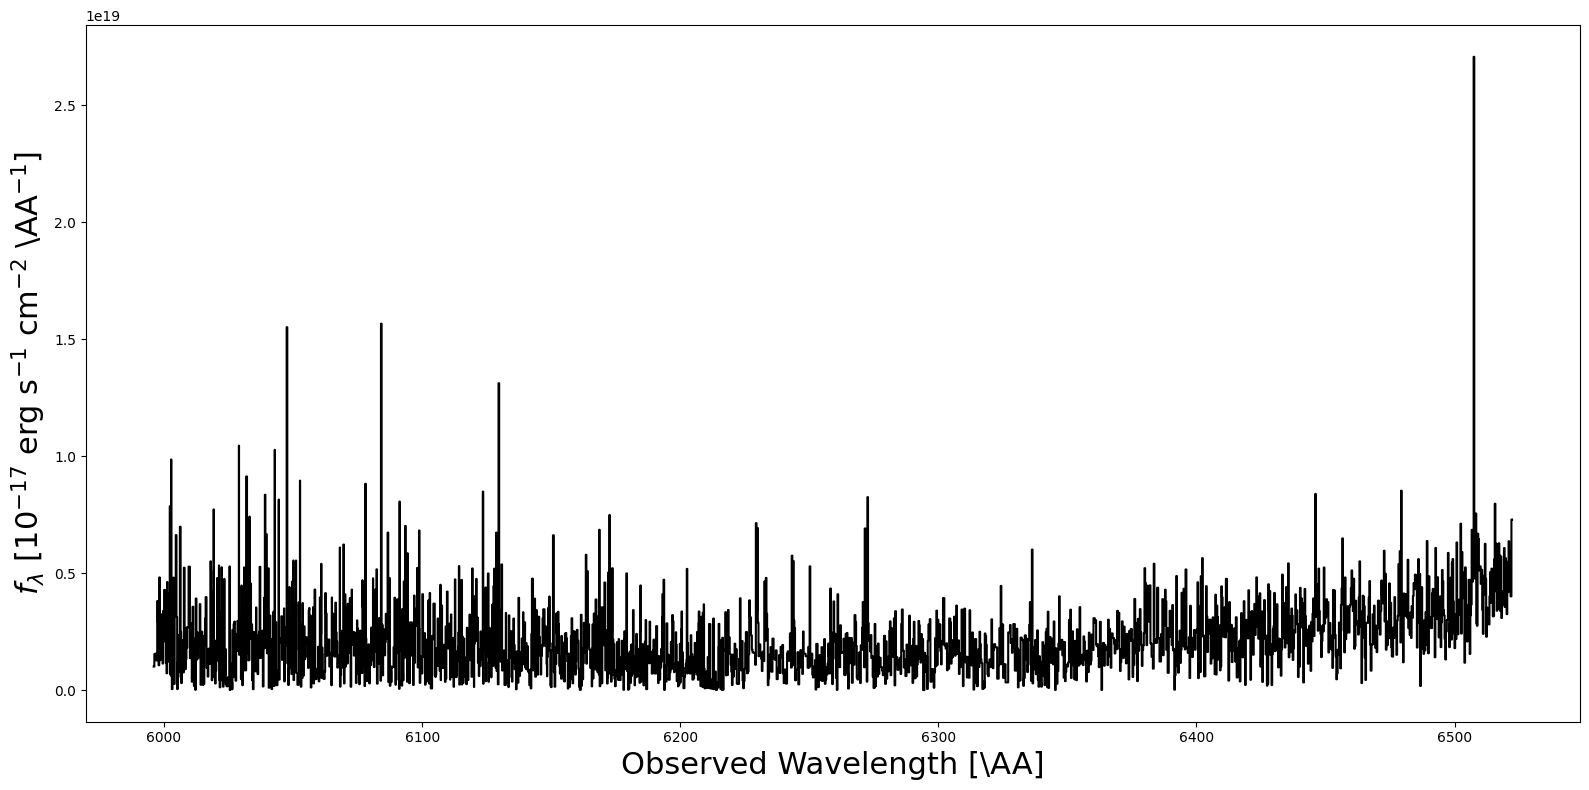

In [42]:
sx1_file='/home/serat/Downloads/AGN/data/region2.fits'
with fits.open(sx1_file) as new_hdu:
    new_dat = new_hdu[1].data
    wave_new = new_dat['wavelength']
    flux_new = (1e17) * new_dat['flux']
    err_new = (1e17) * new_dat['error']
   
   # Create a mask for positive flux values
mask = flux_new > 0
   # Apply the mask
wave_new = wave_new[mask]
flux_new = flux_new[mask]
err_new = err_new[mask]

ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
xtit = 'Observed Wavelength [\AA]'

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
ax1.plot(wave_new / (1 + 0.081), flux_new, drawstyle='steps-mid', color='k')
#ax1.set_ylim([0, 200])
# ax1.set_xlim([2800, 5800])
ax1.set_ylabel(ytit, size=22)
ax1.set_xlabel(xtit, size=22)
plt.tight_layout()
plt.show()

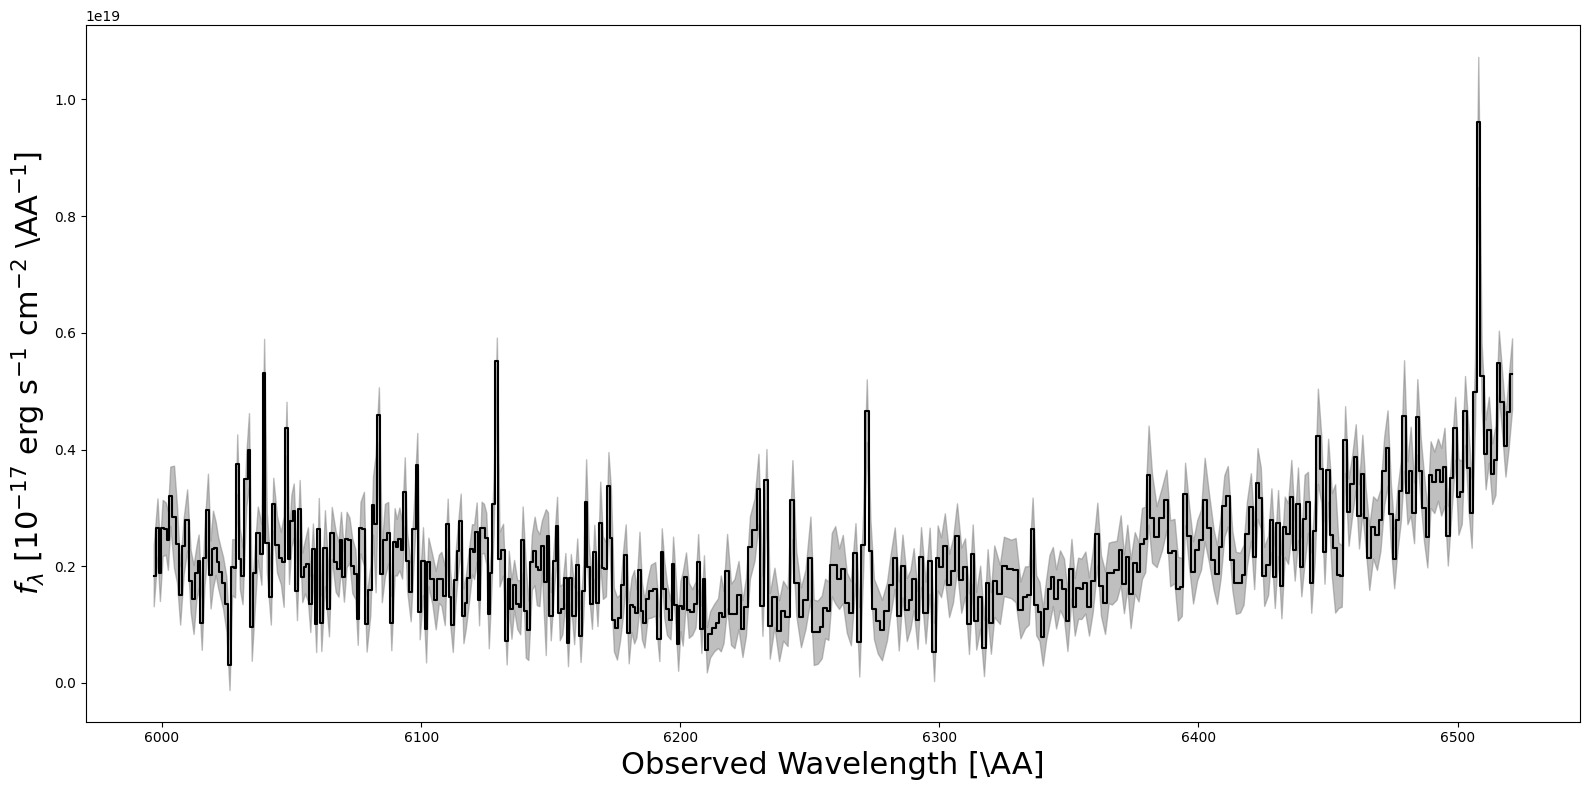

In [40]:
def bin_data(wave, flux, err, bin_size):
    # Determine the number of bins
    num_bins = len(wave) // bin_size
    binned_wave = np.zeros(num_bins)
    binned_flux = np.zeros(num_bins)
    binned_err = np.zeros(num_bins)
    
    for i in range(num_bins):
        start = i * bin_size
        end = start + bin_size
        binned_wave[i] = np.mean(wave[start:end])
        binned_flux[i] = np.mean(flux[start:end])
        binned_err[i] = np.sqrt(np.sum(err[start:end]**2)) / bin_size  # Assuming errors add in quadrature
    
    return binned_wave, binned_flux, binned_err

# Loop over the files and plot both versions
bin_size = 5  # Adjust bin size as needed

new_hdu = fits.open(sx1_file)
new_dat = new_hdu[1].data
wave_new = new_dat['wavelength']
flux_new = (1e17) * new_dat['flux']
err_new = (1e17) * new_dat['error']

# Bin the data
binned_wave, binned_flux, binned_err = bin_data(wave_new, flux_new, err_new, bin_size)

# Plot the binned data
ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
xtit = 'Observed Wavelength [\AA]'
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
ax1.plot(binned_wave / (1 + 0.081), binned_flux, drawstyle='steps-mid', color='k')
ax1.fill_between(binned_wave / (1 + 0.081), binned_flux - binned_err, binned_flux + binned_err, color='gray', alpha=0.5)
#ax1.axvline(x=4861, color='r', linestyle='--', linewidth=1, label='H-beta (4861 \AA)')
#ax1.set_ylim([0, 200])
# ax1.set_xlim([2800, 5800])
ax1.set_ylabel(ytit, size=22)
ax1.set_xlabel(xtit, size=22)
plt.tight_layout()
plt.show()

# Halpha

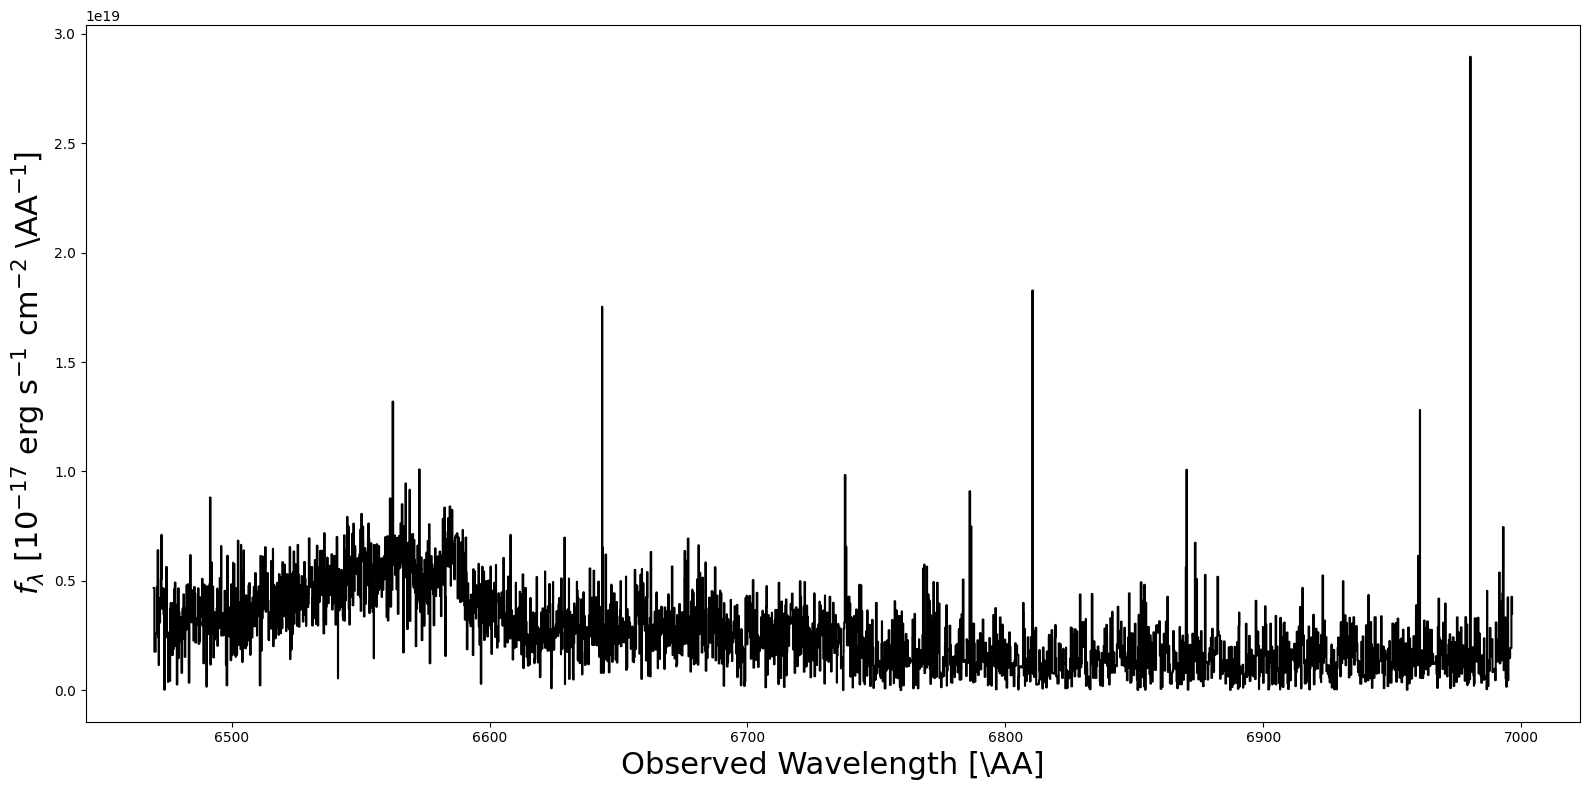

In [9]:
sx1_file='/home/serat/Downloads/AGN/data/region3.fits'
with fits.open(sx1_file) as new_hdu:
    new_dat = new_hdu[1].data
    wave_new = new_dat['wavelength']
    flux_new = (1e17) * new_dat['flux']
    err_new = (1e17) * new_dat['error']
   
   # Create a mask for positive flux values
mask = flux_new > 0
   # Apply the mask
wave_new = wave_new[mask]
flux_new = flux_new[mask]
err_new = err_new[mask]

ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
xtit = 'Observed Wavelength [\AA]'

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
ax1.plot(wave_new / (1 + 0.081), flux_new, drawstyle='steps-mid', color='k')
#ax1.set_ylim([0, 200])
# ax1.set_xlim([2800, 5800])
ax1.set_ylabel(ytit, size=22)
ax1.set_xlabel(xtit, size=22)
plt.tight_layout()
plt.show()

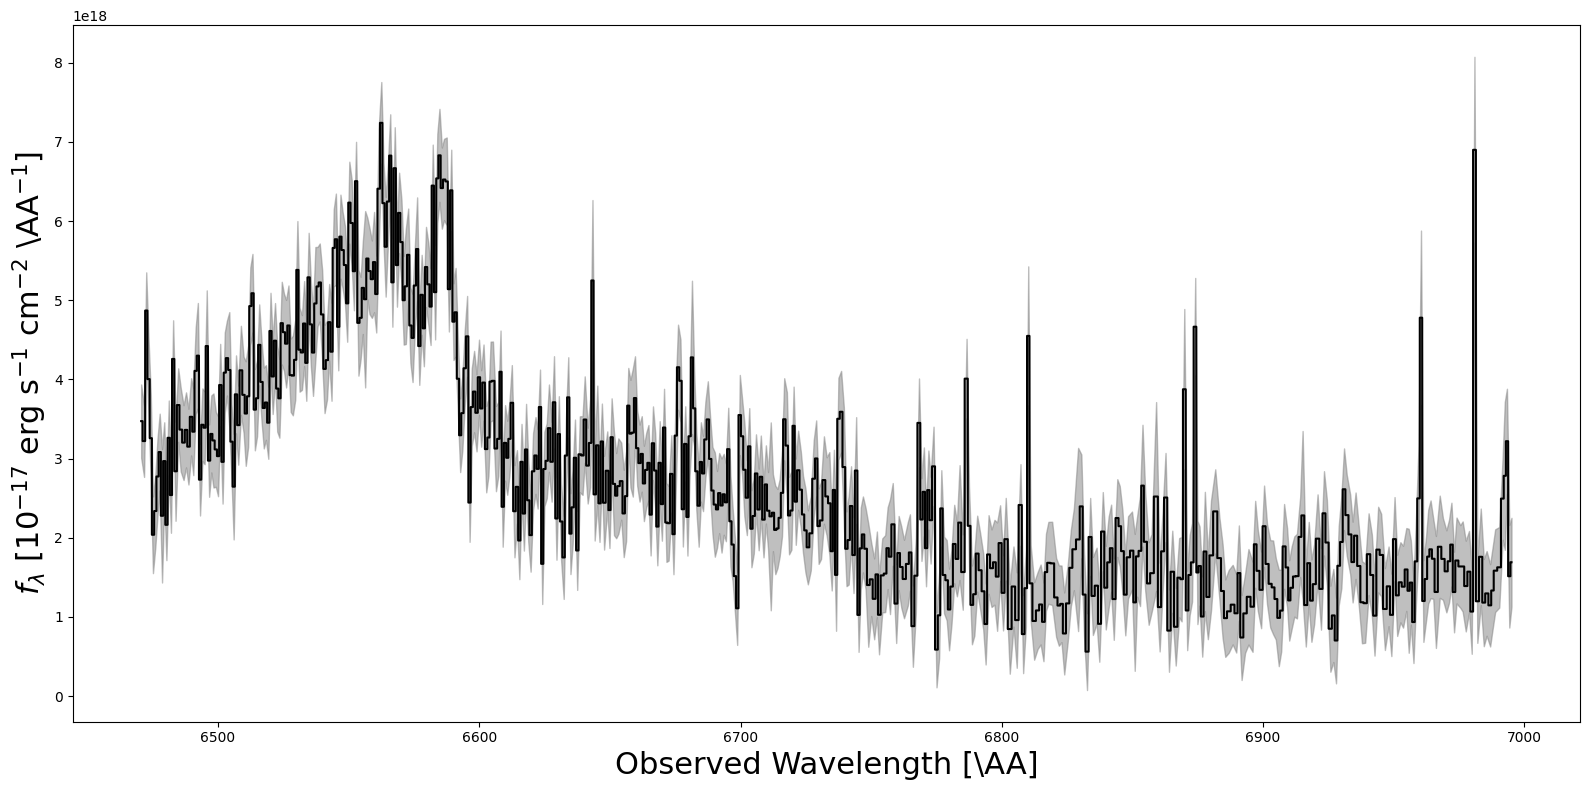

In [10]:
def bin_data(wave, flux, err, bin_size):
    # Determine the number of bins
    num_bins = len(wave) // bin_size
    binned_wave = np.zeros(num_bins)
    binned_flux = np.zeros(num_bins)
    binned_err = np.zeros(num_bins)
    
    for i in range(num_bins):
        start = i * bin_size
        end = start + bin_size
        binned_wave[i] = np.mean(wave[start:end])
        binned_flux[i] = np.mean(flux[start:end])
        binned_err[i] = np.sqrt(np.sum(err[start:end]**2)) / bin_size  # Assuming errors add in quadrature
    
    return binned_wave, binned_flux, binned_err

# Loop over the files and plot both versions
bin_size = 5  # Adjust bin size as needed

new_hdu = fits.open(sx1_file)
new_dat = new_hdu[1].data
wave_new = new_dat['wavelength']
flux_new = (1e17) * new_dat['flux']
err_new = (1e17) * new_dat['error']

# Bin the data
binned_wave, binned_flux, binned_err = bin_data(wave_new, flux_new, err_new, bin_size)

# Plot the binned data
ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
xtit = 'Observed Wavelength [\AA]'
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
ax1.plot(binned_wave / (1 + 0.081), binned_flux, drawstyle='steps-mid', color='k')
ax1.fill_between(binned_wave / (1 + 0.081), binned_flux - binned_err, binned_flux + binned_err, color='gray', alpha=0.5)
#ax1.axvline(x=4861, color='r', linestyle='--', linewidth=1, label='H-beta (4861 \AA)')
#ax1.set_ylim([0, 200])
# ax1.set_xlim([2800, 5800])
ax1.set_ylabel(ytit, size=22)
ax1.set_xlabel(xtit, size=22)
plt.tight_layout()
plt.show()

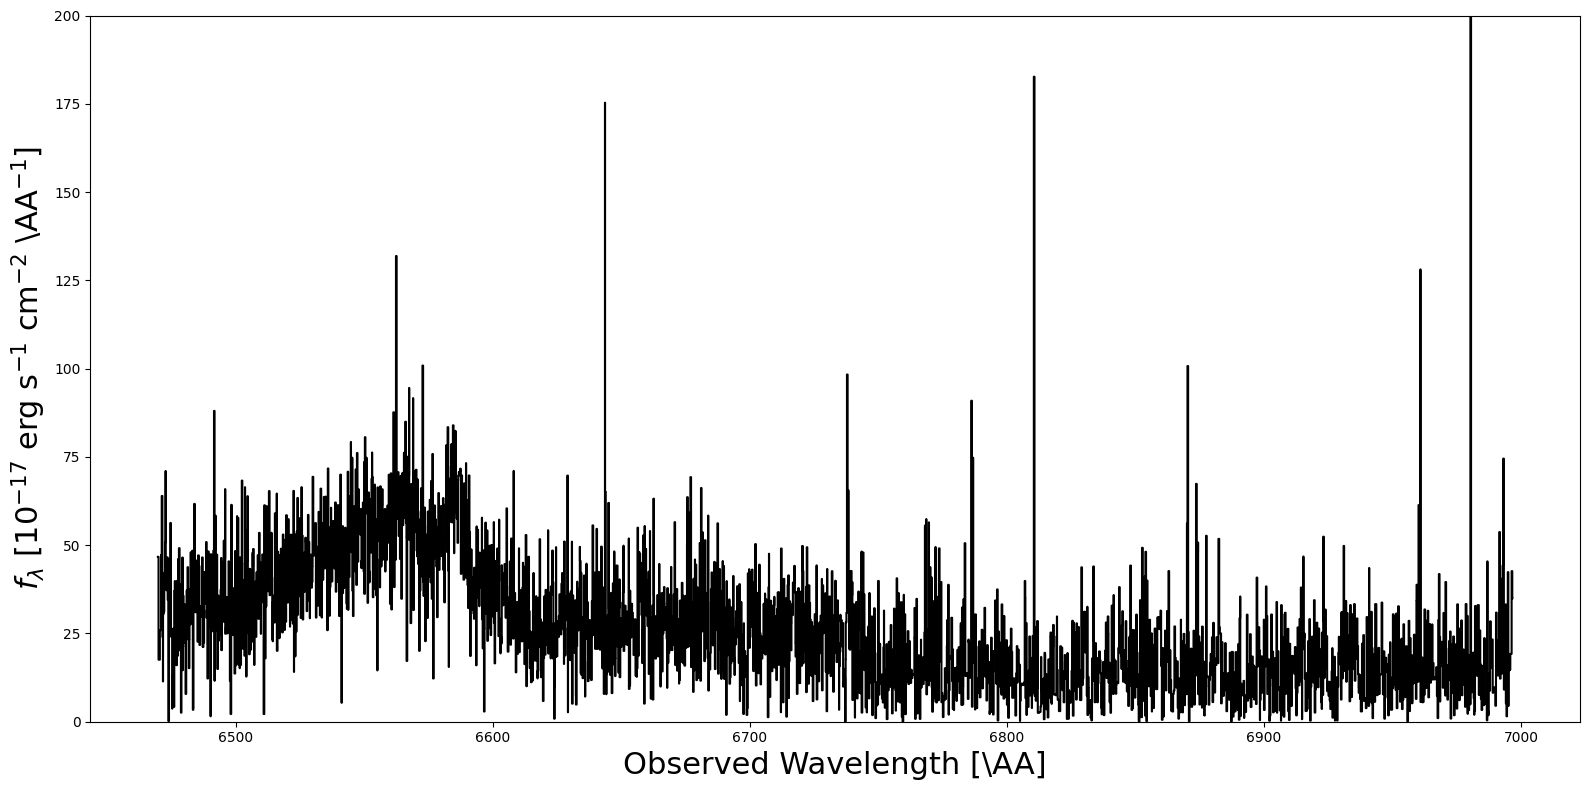

In [29]:
# Define the directory containing the FITS files
data_directory = '/home/serat/Downloads/AGN/data'

# List of specific FITS files
fits_files = [
    os.path.join(data_directory, 'of0a02070_1D.fits'),
    os.path.join(data_directory, 'of0a02080_1D.fits'),
    os.path.join(data_directory, 'of0a02090_1D.fits')
]

# Initialize lists to store combined data
combined_wave = []
combined_flux = []
combined_err = []

# Loop through each FITS file and extract data
for file in fits_files:
    with fits.open(file) as hdul:
        data = hdul[1].data
        wave = data['wavelength'][0]
        flux = (1e17) * data['flux'][0]
        err = (1e17) * data['error'][0]
        
        # Create a mask for positive flux values
        mask = flux > 0
        
        # Apply the mask and combine data
        combined_wave.append(wave[mask])
        combined_flux.append(flux[mask])
        combined_err.append(err[mask])

# Concatenate combined data
combined_wave = np.concatenate(combined_wave)
combined_flux = np.concatenate(combined_flux)
combined_err = np.concatenate(combined_err)

# Sort the combined data by wavelength
sorted_indices = np.argsort(combined_wave)
combined_wave = combined_wave[sorted_indices]
combined_flux = combined_flux[sorted_indices]
combined_err = combined_err[sorted_indices]

# Save the combined data to a new FITS file
col1 = fits.Column(name='wavelength', format='D', array=combined_wave)
col2 = fits.Column(name='flux', format='D', array=combined_flux)
col3 = fits.Column(name='error', format='D', array=combined_err)

hdu = fits.BinTableHDU.from_columns([col1, col2, col3])
hdu.writeto(os.path.join(data_directory, 'region3.fits'), overwrite=True)

# Plot the combined spectra
ytit = '$f_{\lambda}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
xtit = 'Observed Wavelength [\AA]'

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
ax1.plot(combined_wave / (1 + 0.081), combined_flux, drawstyle='steps-mid', color='k')
ax1.set_ylim([0, 200])
# ax1.set_xlim([2800, 5800])
ax1.set_ylabel(ytit, size=22)
ax1.set_xlabel(xtit, size=22)
plt.tight_layout()
plt.show()

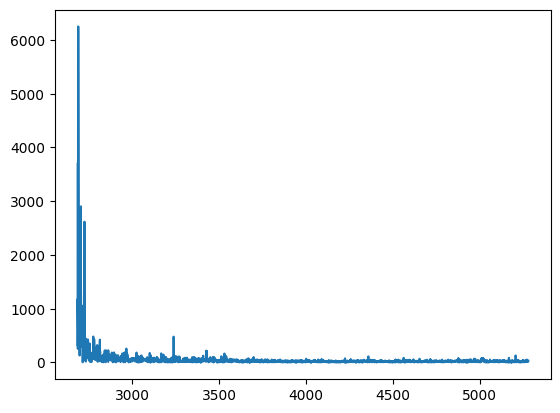

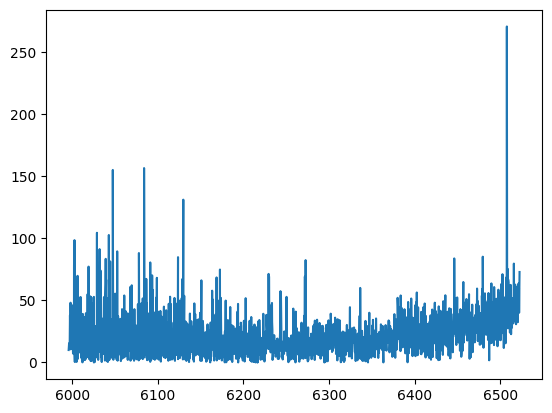

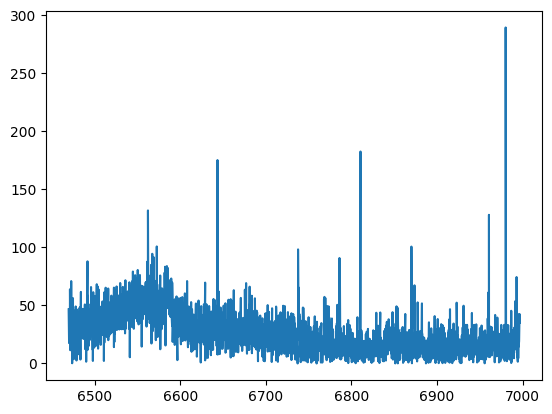

[array([2682.88015983, 2685.33087711, 2685.41918585, ..., 5275.95835265,
       5278.48811611, 5278.48885065]), array([5995.99585872, 5996.51055844, 5996.67284585, ..., 6521.61185659,
       6521.77283349, 6522.2836475 ]), array([6469.74133251, 6470.25599778, 6470.77066498, ..., 6996.03949079,
       6996.54906287, 6996.54984294])]


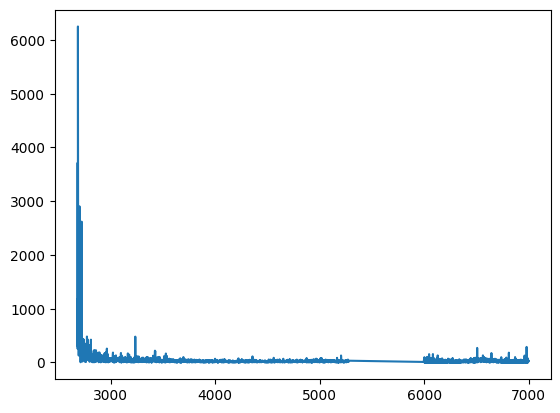

In [44]:
# Define the directory containing the FITS files
data_directory = '/home/serat/Downloads/AGN/data'

# List of FITS files for regions
fits_files = ['/home/serat/Downloads/AGN/data/region1.fits',
              '/home/serat/Downloads/AGN/data/region2.fits',
              '/home/serat/Downloads/AGN/data/region3.fits']

# Initialize lists to store combined data
combined_wave = []
combined_flux = []
combined_err = []

# Loop through each FITS file and extract data
for file in fits_files:
    with fits.open(file) as hdul:
        data = hdul[1].data
        wave = data['wavelength'] / (1 + 0.081)
        flux = data['flux']
        err = data['error']

        plt.plot(wave, flux)
        plt.show()
        # Create a mask for positive flux values
        #mask = flux > 0
        
        # Apply the mask and combine data
        combined_wave.append(wave)
        combined_flux.append(flux)
        combined_err.append(err)

print(combined_wave)
# Concatenate combined data
combined_wave = np.concatenate(combined_wave)
combined_flux = np.concatenate(combined_flux)
combined_err = np.concatenate(combined_err)

# Sort the combined data by wavelength
sorted_indices = np.argsort(combined_wave)
combined_wave = combined_wave[sorted_indices]
combined_flux = combined_flux[sorted_indices]
combined_err = combined_err[sorted_indices]

plt.plot(combined_wave, combined_flux)
plt.show()
#Save the combined data to a new FITS file
col1 = fits.Column(name='wavelength', format='D', array=combined_wave)
col2 = fits.Column(name='flux', format='D', array=combined_flux)
col3 = fits.Column(name='error', format='D', array=combined_err)

hdu = fits.BinTableHDU.from_columns([col1, col2, col3])
output_file = os.path.join(data_directory, 'combined_regions.fits')
hdu.writeto(output_file, overwrite=True)


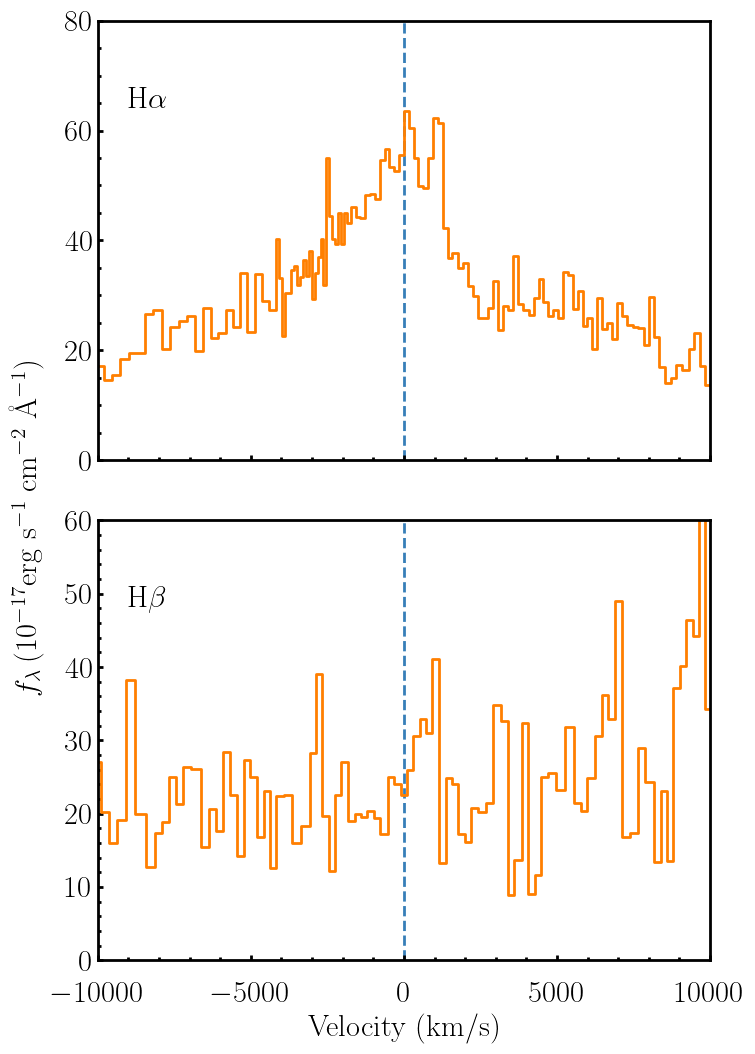

In [28]:
plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22,
    'axes.linewidth': 2,  # Set default axis linewidth
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2
})

# Define constants
c = 299792.458
lambda_0_halpha = 6562
lambda_0_hbeta = 4861  # Example central wavelength for H-beta, adjust as needed

def wavelength_to_velocity(wavelength, lambda_0):
    return c * (wavelength - lambda_0) / lambda_0

def bin_data(velocity, flux, bin_size):
    num_bins = len(velocity) // bin_size
    binned_velocity = np.zeros(num_bins)
    binned_flux = np.zeros(num_bins)
    
    for i in range(num_bins):
        start = i * bin_size
        end = start + bin_size
        binned_velocity[i] = np.mean(velocity[start:end])
        binned_flux[i] = np.mean(flux[start:end])
    
    return binned_velocity, binned_flux

# Read the data from the FITS file
t = Table.read('/home/serat/Downloads/AGN/data/combined_regions.fits')

# Convert wavelength to velocity for H-alpha
velocity_halpha = wavelength_to_velocity(t['wavelength'], lambda_0_halpha)
flux_halpha = t['flux']
binned_velocity_halpha, binned_flux_halpha = bin_data(velocity_halpha, flux_halpha, bin_size=20)

# Convert wavelength to velocity for H-beta
velocity_hbeta = wavelength_to_velocity(t['wavelength'], lambda_0_hbeta)
flux_hbeta = t['flux']
binned_velocity_hbeta, binned_flux_hbeta = bin_data(velocity_hbeta, flux_hbeta, bin_size=4)

# Plot the binned velocity profiles
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 11), sharex=True)

# Define the common line width
line_width = 2.0

# Function to set the border width of the axes
def set_border_width(ax, width):
    for spine in ax.spines.values():
        spine.set_linewidth(width)

# Set up x-axis ticks
major_ticks = np.arange(-10000, 10001, 5000)
minor_ticks = np.arange(-10000, 10001, 1000)

# Plot H-alpha
ax1.axvline(x=0, color='#377eb8', linestyle='--', linewidth=line_width, zorder=1)
ax1.plot(binned_velocity_halpha, binned_flux_halpha, color="#ff7f00", drawstyle='steps-mid', linewidth=line_width, zorder=2)
ax1.set_xlim(-10000, 10000)
ax1.set_ylim(0, 80)
ax1.text(0.05, 0.85, r'H$\alpha$', transform=ax1.transAxes, verticalalignment='top')
set_border_width(ax1, line_width)
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)

# Plot H-beta
ax2.axvline(x=0, color='#377eb8', linestyle='--', linewidth=line_width, zorder=1)
ax2.plot(binned_velocity_hbeta, binned_flux_hbeta, color="#ff7f00", drawstyle='steps-mid', linewidth=line_width, zorder=2)
ax2.set_xlim(-10000, 10000)
ax2.set_ylim(0, 60)
ax2.text(0.05, 0.85, r'H$\beta$', transform=ax2.transAxes, verticalalignment='top')
set_border_width(ax2, line_width)
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)

# Common y-axis label
fig.text(0.04, 0.5, r'$f_{\lambda} \:(10^{-17} \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}})$', va='center', rotation='vertical')

# Add minor ticks and set tick parameters
for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', width=line_width)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='x', which='minor', pad=10)

ax2.set_xlabel("Velocity (km/s)")

plt.tight_layout(rect=[0.05, 0, 1, 1])
#plt.savefig("decomposed_spectra.pdf", format='pdf', bbox_inches='tight')
plt.show()

(0.0, 100.0)

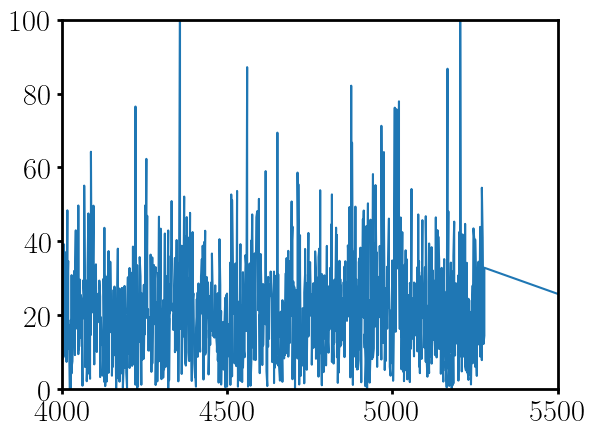

In [79]:
plt.plot(t['wavelength'], t['flux'])
plt.xlim(4000, 5500)
plt.axvline(6561, c='r')
plt.ylim(0, 100)